In [1]:
import tensorflow as tf
import model_vae_tf

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns

from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time
import pickle

import sys
sys.path.append('/home/mz1482/project/my_work/bayesopt/')
sys.path.append('/home/mz1482/project/my_work/ep_models/')
from bayes_opt import BayesianOptimization
# from bayes_opt import testbo
from ep_models import test_model
from skimage.filters import threshold_otsu
import math
from numpy.linalg import multi_dot

/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3

In [2]:
!pip list | grep tensorflow*

tensorflow                        1.14.0              
tensorflow-estimator              1.14.0              


In [3]:
#case1: 1239
#case2: 1373
#case3:1230

# filename = 'shakil_ir_1230' 
filename = 'training_ir_ic_1230' 
resultspath = '/home/mz1482/project/my_work/models/'
use_cpd = True
p_dim = 1230 # optimized data dim
latent_dim = 2

In [4]:
if use_cpd:
    if (p_dim == 1373):
        vae_pdim = 1230
        filename = 'training_ir_ic_1230' 
        correspond_mfile = scipy.io.loadmat('non_rigid_reg/corr3to2.mat',squeeze_me=True,struct_as_record=False)
        correspondance=correspond_mfile['Correspondence']
    elif (p_dim == 1230):
        vae_pdim = 1239
        filename = 'training_ir_ic_1239' 
        correspond_mfile = scipy.io.loadmat('non_rigid_reg/corr1to3.mat',squeeze_me=True,struct_as_record=False)
        correspondance=correspond_mfile['Correspondence']
    else:
        vae_pdim = 1230
        filename = 'training_ir_ic_1230' 
        correspond_mfile = scipy.io.loadmat('non_rigid_reg/corr3to1.mat',squeeze_me=True,struct_as_record=False)
        correspondance=correspond_mfile['Correspondence']
else:
    correspondance = 1
    vae_pdim = p_dim
correspondance = correspondance - 1
print("hello")

hello


In [5]:
print(vae_pdim)
print(correspondance)

1239
[ 701  697  707 ... 1237  610  611]


In [6]:
tf.reset_default_graph() # remove all tensors in default graph
network_architecture = dict(n_hidden_recog_1=512, # 1st layer encoder neurons
         n_hidden_recog_2=512, # 2nd layer encoder neurons
         n_hidden_gener_1=512, # 1st layer decoder neurons
         n_hidden_gener_2=512, # 2nd layer decoder neurons
         n_input=vae_pdim, # data input dimensionality (e.g., MNIST img shape: 28*28)
         n_z=latent_dim)  # dimensionality of the latent space

vae = model_vae_tf.VariationalAutoencoder(network_architecture, 
                             learning_rate=0.001, 
                             batch_size=64)

vae.load(resultspath + filename + "/m_" + str(latent_dim) + "d")








Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/mz1482/project/my_work/models/training_ir_ic_1239/m_2d
loaded model weights from /home/mz1482/project/my_work/models/training_ir_ic_1239/m_2d


In [7]:
with open(resultspath + filename + "/z_posterior.pkl", 'rb') as input:
        z_mu_1 =  pickle.load(input)
        z_var_1 = pickle.load(input)
        z_mu_5 = pickle.load(input)
        z_var_5 = pickle.load(input)
        z_alpha_5 = pickle.load(input)

In [8]:
rpath="./results/"
dpath="./data_sets/synthetic_cases/"
# files = ['case3_inf_e4'] #RPA case
# files = ['case3_inf_e4','case3_large','case3_sep_e2','case3_ant_e2','case3_lat_e2','case3_ant_1','case3_antsp_1','case3_inf_1','case3_inf_lat_2','case3_ap_1','case3_inf_2','case3_inf_lat_1','case3_infsp_1']
# files = ['mysimu']
files = ['case3_ant_1']
# files = ['case3_coordin','case3_bas_ant','case3_mid_ant','case3_ap_ant'] 
rpath =  rpath + 'case3/'
dpath = dpath + 'case3/'

In [9]:
# rpath="./results/"
# dpath="./data_sets/synthetic_cases/"
# files = ['case2_ant_e1','case2_ant_e1','case2_inf_e3','case2_lat_e4','case2_sep_e4']
# # files = ['mysimu']
# rpath =  rpath + 'case2/'
# dpath = dpath + 'case2/'

In [10]:
len(files)

1

In [11]:
def data_drop(x,percent):
    start_point = math.floor(len(x)*percent/100)
    new_x = x[start_point:,:]
    return new_x

def manage_data(data,percent):
    chain1 = data[np.where(data[:, 0] == 0)]
    chain2 = data[np.where(data[:, 0] == 1)]
    chain1 = data_drop(chain1,percent)
    chain2 = data_drop(chain2,percent)
    new_data = np.vstack([chain1,chain2])
    return new_data

percent = 20

def mean_std_mode(data,percent,p_dim,vae_pdim,correspond):
    data = manage_data(data,percent)
    z1=data[:,1]
    z2=data[:,2]
    newz = np.column_stack([z1,z2])
    sample_theta = np.empty((vae_pdim,0))
    for i in range(len(newz)):
        mean_z = np.array([newz[i]]*vae.batch_size)
        par = vae.generate(mean_z)
        parTrue_mean = par[0].reshape(vae_pdim,1)
        sample_theta = np.append(sample_theta,parTrue_mean,axis =1)
    mean_theta = np.mean(sample_theta,axis = 1).reshape(vae_pdim,1)
    mean_theta = mean_theta[correspond]
    std=np.sqrt(np.mean((sample_theta-np.mean(sample_theta,axis=1).reshape(vae_pdim,1))**2,1)).reshape(vae_pdim,1)
    std = std[correspond]
    mode_z = data[data[:,3]==np.amax(data[:,3])][:,1:3]
    mode_z = np.array([mode_z[0]]*vae.batch_size)
    mode_par = vae.generate(mode_z)
    mode = mode_par[0].reshape(vae_pdim,1)
    mode_theta = mode[correspond]
    return mean_theta,mode_theta,std 

In [11]:
# niter =  100
niter =  10
inipts = 20
# inipts = 2
# acq_list  = ['ei', 'ei_prior', 'ei_post_agg', 'ucb', 'poi', 'ev', 'entropy','ei_post_k','mode','median','avg','cv']
acq_list  = ['ev']

num_acq  = len(acq_list)
num_exps = len(files)
parUnknownId = list(range(1,latent_dim+1))
bounds = [(-4,4) for ij in parUnknownId]
parUnknownId = [str(ij) for ij in parUnknownId]
timetaken = np.zeros((num_exps,num_acq))
dicecoeff = np.zeros((num_exps,num_acq))
fopt = np.zeros((num_exps,num_acq))
paramEstRes = np.zeros((num_exps,num_acq,p_dim))
paramEstRes_z = np.zeros((num_exps,num_acq,latent_dim))
paramGT = np.zeros((num_exps,num_acq,p_dim))
rmse = np.zeros((num_exps,num_acq))
cc = np.zeros((num_exps,num_acq))
steps = np.zeros((num_exps,num_acq))

In [12]:
dict(zip(parUnknownId, bounds))

{'1': (-4, 4), '2': (-4, 4)}

In [14]:
data = np.loadtxt("true_mcmc.txt", delimiter=",")
# data = manage_data(data,percent)
z1= data[:,1]
z2 = data[:,2]
y = data[:,3]
# zz = np.hstack([z1.reshape(-1,1),z2.reshape(-1,1)])

0
complete
time taken for iteration 81.3869686126709 seconds
time taken for iteration 8.605565309524536 seconds
time taken for iteration 17.557249546051025 seconds
time taken for iteration 7.998749494552612 seconds
time taken for iteration 8.113948822021484 seconds
time taken for iteration 4.529186010360718 seconds
kl is -0.4749267771855279
time taken for iteration 3.5624983310699463 seconds
kl is -0.4748746399914796
time taken for iteration 7.939483642578125 seconds
kl is -0.410268701260062
time taken for iteration 8.26238751411438 seconds
kl is -0.3383245732928173
time taken for iteration 5.002918720245361 seconds
kl is -0.3375402734955779
time taken for iteration 8.016741275787354 seconds
kl is 2.5493799518188602
time taken for iteration 8.115036725997925 seconds
kl is 2.0850475494202962
time taken for iteration 7.71522068977356 seconds
kl is 2.428887618994916
time taken for iteration 12.992232322692871 seconds
kl is 3.5760380438449415
time taken for iteration 27.600348711013794 sec

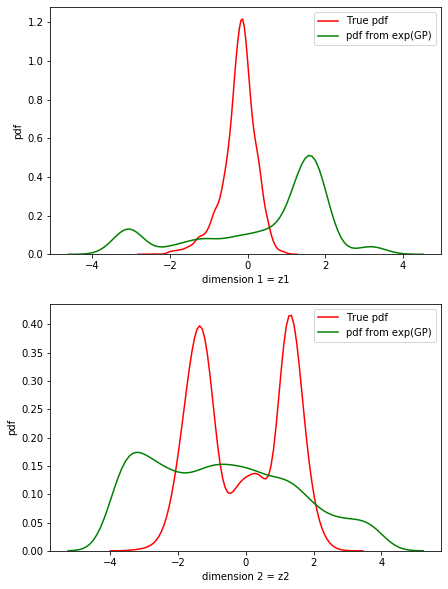

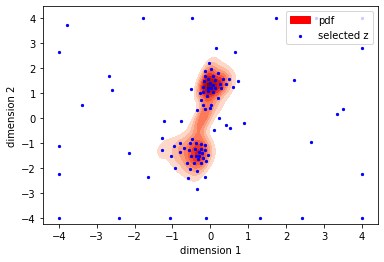

exp #1 with entropy: 0.12154696132596685, 0.22406639004149378, 0.12328476990538745,0.22804749474939676,-0.08203607749728525,0.10896251989011994,100
time taken for iteration 76.30099940299988 seconds
time taken for iteration 8.217418193817139 seconds
time taken for iteration 17.478557348251343 seconds
time taken for iteration 7.97658634185791 seconds
time taken for iteration 8.064204931259155 seconds
time taken for iteration 7.062007665634155 seconds
kl is -0.45765591949793577
time taken for iteration 3.5524778366088867 seconds
kl is -0.4575943323522606
time taken for iteration 7.896807670593262 seconds
kl is 2.6951910098560616
time taken for iteration 8.239498615264893 seconds
kl is -0.3149772772795904
time taken for iteration 4.978328704833984 seconds
kl is -0.31412150428594265
time taken for iteration 8.011346578598022 seconds
kl is 4.885052102008589
time taken for iteration 8.10230040550232 seconds
kl is 1.4611346583082216
time taken for iteration 8.028345584869385 seconds
kl is 2.8

/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:545: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01396062,  0.03598289]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


kl is 2.519352968504574
time taken for iteration 8.519515991210938 seconds
kl is 1.3715970310329373
time taken for iteration 3.9641799926757812 seconds
kl is 2.2847359045435636
time taken for iteration 7.0736236572265625 seconds
kl is 1.775325594317943
time taken for iteration 7.170855283737183 seconds
kl is 1.8562516334106798
time taken for iteration 8.280429124832153 seconds
kl is 1.5675373449426673
time taken for iteration 3.8992819786071777 seconds
kl is 1.5887958662792983
time taken for iteration 3.6253602504730225 seconds
kl is 1.6046952571271482
time taken for iteration 7.718521356582642 seconds
kl is 1.7627049374033055
time taken for iteration 3.87442946434021 seconds
kl is 2.0451521733186007
time taken for iteration 62.82573390007019 seconds
kl is 1.8588120175075706
time taken for iteration 11.74511194229126 seconds
kl is 2.010354557739595
time taken for iteration 7.139320373535156 seconds
kl is 2.017249153367041
time taken for iteration 7.239780902862549 seconds
kl is 1.40501

/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:545: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-151.73713425, -219.88196507]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


time taken for iteration 8.944098711013794 seconds
kl is 0.9302208772176555
time taken for iteration 3.7508275508880615 seconds
kl is 0.9492040699772081
time taken for iteration 9.1883385181427 seconds
kl is 0.9693161981347158
time taken for iteration 7.1270856857299805 seconds
kl is 0.860737964444396


/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:545: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-537.99196643, -551.95237991]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


time taken for iteration 234.33019089698792 seconds
kl is 1.0235255838982982
time taken for iteration 7.42636513710022 seconds
kl is 1.0271606363213235
time taken for iteration 6.823666572570801 seconds
kl is 1.1426280571479726
time taken for iteration 8.12158465385437 seconds
kl is 1.1160912773468743
time taken for iteration 8.14710283279419 seconds


/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:431: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:431: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


kl is 1.1100073144098566
time taken for iteration 6.904862642288208 seconds
kl is 1.045931542049934
time taken for iteration 6.87173318862915 seconds
kl is 1.0067165122699053
time taken for iteration 63.51548099517822 seconds
kl is 0.5273970028612693
time taken for iteration 8.13892126083374 seconds
kl is 0.5796711240958933
time taken for iteration 182.27260828018188 seconds
kl is 0.844344824407483
time taken for iteration 7.456759214401245 seconds
kl is 0.6033221062080137
time taken for iteration 3.571286201477051 seconds
kl is 1.0248534107089375
time taken for iteration 8.19127631187439 seconds
kl is 1.0586787886298659
time taken for iteration 7.04090142250061 seconds
kl is 1.065717090997863
time taken for iteration 8.126410007476807 seconds
kl is 1.0706318511240138
time taken for iteration 8.204214811325073 seconds
kl is 1.0681367744189145
time taken for iteration 8.401731491088867 seconds
kl is 1.0391640240333628
time taken for iteration 6.960049629211426 seconds
kl is 1.0420088850

/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:431: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:431: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


kl is 0.9494370833070161
time taken for iteration 8.13309097290039 seconds
kl is 0.9350631064811833
time taken for iteration 11.832312107086182 seconds
kl is 0.9356846438833415
time taken for iteration 8.375370025634766 seconds
kl is 0.819922972896512
time taken for iteration 8.55736255645752 seconds
kl is 0.8078881874057482
time taken for iteration 7.336660861968994 seconds
kl is 0.7945915343616509
time taken for iteration 6.917464971542358 seconds
kl is 0.7947871849349057
time taken for iteration 7.190176248550415 seconds
kl is 0.6920829073517514
time taken for iteration 7.309806823730469 seconds


/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:431: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


kl is 0.6859099413874493
time taken for iteration 7.097991704940796 seconds
kl is 0.7184112002834326
time taken for iteration 7.180492162704468 seconds
kl is 0.7469975627801427
time taken for iteration 7.1747331619262695 seconds
kl is 0.7202164616355564
time taken for iteration 8.22616457939148 seconds


/home/mz1482/project/my_work/bayesopt/bayes_opt/gprmy.py:545: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00222181, 0.02823472]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 12, 'warnflag': 2}
  " state: %s" % convergence_dict)


kl is 0.7474504987997862
time taken for iteration 7.516844987869263 seconds
kl is 0.7172498237173567
time taken for iteration 7.013806581497192 seconds
kl is 0.7358398985139236
time taken for iteration 7.300214767456055 seconds
kl is 0.6955316603268005
time taken for iteration 6.950838565826416 seconds
kl is 0.2715198406796685
acceptence rate is 0.16915
iteration no is  120


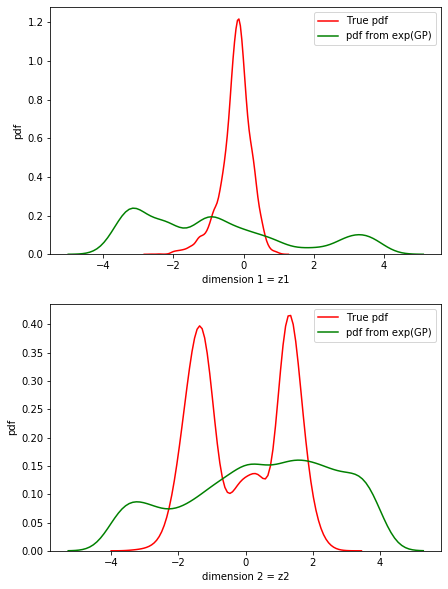

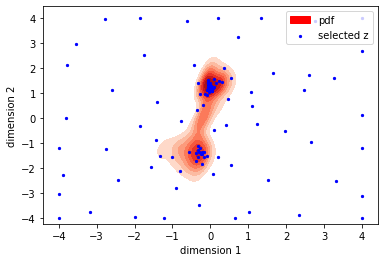

exp #1 with ucb: 0.19559228650137742, 0.3185840707964602, 0.12836335237807514,0.231778637863323,0.014705723828081272,0.2977583256313716,121
time taken for iteration 75.76241827011108 seconds
time taken for iteration 8.36415982246399 seconds
time taken for iteration 17.926265239715576 seconds
time taken for iteration 7.981342077255249 seconds
time taken for iteration 8.538366317749023 seconds
time taken for iteration 7.384393930435181 seconds
kl is -0.4578959625888093
time taken for iteration 3.759251594543457 seconds
kl is -0.4578342754178639
time taken for iteration 7.804269790649414 seconds
kl is -0.3895690122674168
time taken for iteration 8.357180118560791 seconds
kl is -0.31526140682559095
time taken for iteration 5.080608606338501 seconds
kl is -0.31440611409433034
time taken for iteration 8.166942358016968 seconds
kl is 4.866140197387657
time taken for iteration 8.313862323760986 seconds
kl is 4.662507114098219
time taken for iteration 7.030879259109497 seconds
kl is -3.61510204

time taken for iteration 8.563586950302124 seconds
kl is 0.3506611330706056
time taken for iteration 7.6179938316345215 seconds
kl is 0.3248907366504295
time taken for iteration 8.508129119873047 seconds
kl is 0.3021986050870494
time taken for iteration 6.161886930465698 seconds
kl is 0.30209991547534876
time taken for iteration 3.5018367767333984 seconds
kl is 0.30258835807781037
time taken for iteration 7.687260389328003 seconds
kl is 0.2982670793525657
acceptence rate is 0.1618
iteration no is  108


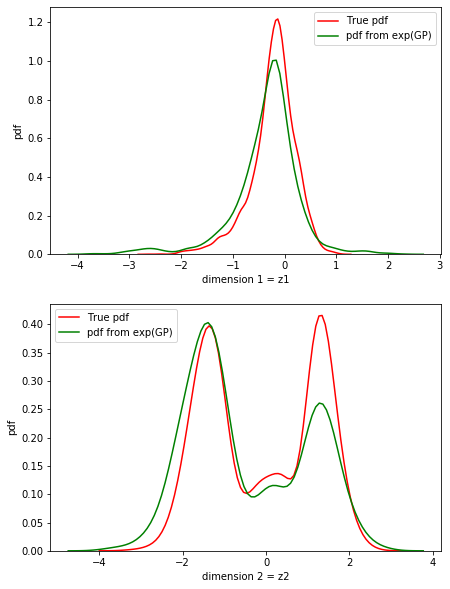

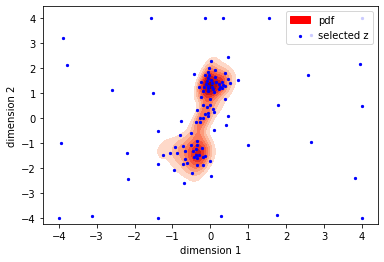

exp #1 with ev: 0.534521158129176, 0.21428571428571427, 0.11611919094043403,0.12117563155229659,0.5823146473359682,0.17347573788877638,109


In [15]:
#print (type(vae))
for i in range(num_exps):  
    fname = files[i] + '.mat'   
    matFiles = scipy.io.loadmat(dpath+fname,squeeze_me=True,struct_as_record=False)
    parTrue=matFiles['parTrue']
    obs=matFiles['obs']
    simu=matFiles['simu']
    corMfree=matFiles['corMfree']
    
    cardiac_model = test_model.Model(simu, obs, parTrue, corMfree, maskidx_12lead = 0
                                ,use_cpd = use_cpd, correspond = correspondance)  
 
    thresh_gt = 0.19#threshold_otsu(cardiac_model.parTrue)
    idx_gt =  np.where(cardiac_model.parTrue>=thresh_gt)[0]
    
    #t,tmp,bsp=cardiac_model.simulate_ecg(parTrue)
    print(i)
    print('complete')
    
    for j in range(num_acq): 
        gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, 
                            dict(zip(parUnknownId, bounds)),vae,verbose=0)
        #gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, zip(parUnknownId, bounds),vae,verbose=0)
        acq_func = acq_list[j]
        tstart = time.time()   
        if(acq_func=='ucb'):            
            gp,Z,sel=gp_surr.exp_gp_shape(init_points=inipts,n_iter=200,acq='ucb',xi=0.,zz=data)
        elif(acq_func=='ev'):            
            gp,Z,sel=gp_surr.exp_gp_shape(init_points=inipts,n_iter=200,acq='ev',xi=0.,zz=data)
        elif(acq_func=='entropy'):            
            gp,Z,sel=gp_surr.exp_gp_shape(init_points=inipts,n_iter=200,acq='entropy',xi=0.,zz=data)
        else:
            print('incorrect acq func')
        tend=time.time()   
        step = len(gp_surr.res['all']['values'])
        mean_true,mode_true,std_true = mean_std_mode(Z,percent,p_dim,vae_pdim,correspondance)
#         xmax = gp_surr.res['max']['max_params']
#         z_mu = np.array([xmax]*vae.batch_size)
#         x_mean = vae.generate(z_mu) 
#         x_mean = x_mean[0]
#         if use_cpd:
#             x_mean = x_mean[correspondance]
        thresh_c_mean = threshold_otsu(mean_true)
        thresh_c_mode = threshold_otsu(mode_true)
        idx_c_mean =  np.where(mean_true>=thresh_c_mean)[0]
        idx_c_mode =  np.where(mode_true>=thresh_c_mode)[0]
        rmse_temp_mean = np.sqrt(((cardiac_model.parTrue - mean_true) ** 2).mean())
        rmse_temp_mode = np.sqrt(((cardiac_model.parTrue - mode_true) ** 2).mean())
        dicecoeff_temp_mean = 2*len(np.intersect1d(idx_gt,idx_c_mean))/(len(idx_gt)+len(idx_c_mean))
        dicecoeff_temp_mode = 2*len(np.intersect1d(idx_gt,idx_c_mode))/(len(idx_gt)+len(idx_c_mode))
        cc_temp_mean = np.corrcoef(cardiac_model.parTrue,mean_true.flatten())[0,1]
        cc_temp_mode = np.corrcoef(cardiac_model.parTrue,mode_true.flatten())[0,1]
        sns.kdeplot(z1,z2,color='r', shade=True, label='pdf', 
            cmap="Reds", shade_lowest=False) 
        plt.scatter(sel[:,0],sel[:,1],color='b',s=5,label = 'selected z')
        plt.xlabel('dimension 1')
        plt.ylabel('dimension 2')
        plt.legend(loc="upper right")
        plt.savefig('selection'+str(j)+'.png')
        plt.show()

#         rmse[i,j] = rmse_temp
#         dicecoeff[i,j] = dicecoeff_temp
#         cc[i,j] = cc_temp
#         steps[i,j] = step
#         paramEstRes[i,j,:] = x_mean
#         paramEstRes_z[i,j,:] = xmax
#         fopt[i,j] = gp_surr.res['max']['max_val']
#         paramGT[i,j,:] = cardiac_model.parTrue
#         timetaken[i,j] = tend-tstart

        print('exp #{} with {}: {}, {}, {},{},{},{},{}'.format(i+1, acq_func, dicecoeff_temp_mean,dicecoeff_temp_mode, rmse_temp_mean,rmse_temp_mode,cc_temp_mean,cc_temp_mode,step ) )

In [16]:
break
np.sqrt(((cardiac_model.parTrue - mean_true.flatten()) ** 2).mean())

SyntaxError: 'break' outside loop (<ipython-input-16-8d1187a48890>, line 4)

In [ ]:
k = Z.T

In [ ]:
k.shape

In [ ]:
fname = files[0] + '.mat'   
matFiles = scipy.io.loadmat(dpath+fname,squeeze_me=True,struct_as_record=False)
parTrue=matFiles['parTrue']
obs=matFiles['obs']
simu=matFiles['simu']
corMfree=matFiles['corMfree']
cardiac_model = test_model.Model(simu, obs, parTrue, corMfree, maskidx_12lead = 0
                            ,use_cpd = use_cpd, correspond = correspondance)  
gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, dict(zip(parUnknownId, bounds)),vae,verbose=0)
# gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei',xi=0.)
# cardiac_model.mapparam2(test_z, vae)
# gp_surr.points_to_csv("abc")


In [ ]:
gp,Z=gp_surr.exp_gp_shape(init_points=inipts,n_iter=100,acq='ucb',xi=0.,zz=data)

In [ ]:
# #print (type(vae))
# for i in range(num_exps):  
#     fname = files[i] + '.mat'   
#     matFiles = scipy.io.loadmat(dpath+fname,squeeze_me=True,struct_as_record=False)
#     parTrue=matFiles['parTrue']
#     obs=matFiles['obs']
#     simu=matFiles['simu']
#     corMfree=matFiles['corMfree']
    
#     cardiac_model = test_model.Model(simu, obs, parTrue, corMfree, maskidx_12lead = 0
#                                 ,use_cpd = use_cpd, correspond = correspondance)   
#     thresh_gt = 0.18#threshold_otsu(cardiac_model.parTrue)
#     idx_gt =  np.where(cardiac_model.parTrue>=thresh_gt)[0]
    
#     #t,tmp,bsp=cardiac_model.simulate_ecg(parTrue)
#     print(i)
#     print('complete')
    
#     for j in range(num_acq): 
#         gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, 
#                             dict(zip(parUnknownId, bounds)),vae,verbose=0)
#         #gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, zip(parUnknownId, bounds),vae,verbose=0)
#         acq_func = acq_list[j]
#         tstart = time.time()   
#         if(acq_func=='ei'):                  
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei',xi=0.)
#         elif(acq_func=='ei_prior'):
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_prior',xi=1.0)
#         elif(acq_func=='ei_post_agg'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_post_agg',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='poi'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='poi',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='ucb'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ucb',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='ev'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ev',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='ev2'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ev2',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='entropy'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='entropy',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='avg'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='avg',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='mode'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='mode',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='median'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='median',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='cv'):            
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='cv',
#                              z_m=z_mu_1, z_v=z_var_1, xi=1.0)
#         elif(acq_func=='ei_post_k'):
#             gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_post_k',
#                              z_a=z_alpha_5, z_m=z_mu_5, z_v=z_var_5, xi=1.0)
#         else:
#             print('incorrect acq func')
#         tend=time.time()   
#         xmax = gp_surr.res['max']['max_params']
#         z_mu = np.array([xmax]*vae.batch_size)
#         x_mean = vae.generate(z_mu) 
#         x_mean = x_mean[0]
#         if use_cpd:
#             x_mean = x_mean[correspondance]
#         thresh_c = threshold_otsu(x_mean)
#         idx_c =  np.where(x_mean>=thresh_c)[0]
#         rmse_temp = np.sqrt(((- x_mean) ** 2).mean())
#         dicecoeff_temp = 2*len(np.intersect1d(idx_gt,idx_c))/(len(idx_gt)+len(idx_c))
#         cc_temp = np.corrcoef(cardiac_model.parTrue,x_mean)[0,1]
        
#         rmse[i,j] = rmse_temp
#         dicecoeff[i,j] = dicecoeff_temp
#         cc[i,j] = cc_temp
#         paramEstRes[i,j,:] = x_mean
#         paramEstRes_z[i,j,:] = xmax
#         fopt[i,j] = gp_surr.res['max']['max_val']
#         paramGT[i,j,:] = cardiac_model.parTrue
#         timetaken[i,j] = tend-tstart

#         print('exp #{} with {}: {}, {}, {},{}'.format(i+1, acq_func, dicecoeff_temp, rmse_temp,cc_temp, timetaken[i,j] ) )

In [ ]:
z1_new = Z[:,1]
z2_new = Z[:,2]

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()

In [ ]:
plt.scatter(design[:,0],design[:,1])
plt.show()

In [ ]:
p = gp.predict(design)

In [ ]:
z_test = data[:,1:3]
z_test.shape

In [ ]:
np.sum(np.log(y/p))/len(p)

In [ ]:

#sampling from exp(gp)
mcmc_chain = 2
z1_new = []
z2_new = []
chain = []
samples = []
for c in range(mcmc_chain):
    zfix = np.random.normal(loc = 0, scale = 1,size=2)
    x_0=np.reshape(zfix,(1,2))
    param = gp.predict(x_0, return_std= True)
    m=param[0].ravel() # mean of gp
    v=param[1].ravel() # sigma of gp
    log_mean_0 = np.exp(m+v**2/2)
    for j in range(10000):      
        z_star = zfix + np.random.normal(loc = 0, scale = 1,size=2)
        z_star2 = np.reshape(z_star,(1,2))
        param2 = gp.predict(z_star2, return_std= True)
        m2=param2[0].ravel() # mean of gp
        v2=param2[1].ravel() # sigma of gp
        log_mean_2 = np.exp(m2+v2**2/2)
        if (-4<z_star[0]<4) and (-4<z_star[1]<4):
            rho = min(1, log_mean_2/log_mean_0)
            r=np.random.rand()
            if r < rho:
                f= open("/home/mz1482/project/my_work/case3_ant_1/case3_ant_1_liklihood_reg.txt","a")
                f.write(str(c) + "," + str(z_star[0]) + "," + str(z_star[1]) + "," + str(log_mean_2[0]) +"\n")
                f.close()
                zfix = z_star
                log_mean_0 = log_mean_2
                z1_new = np.append(z1_new,z_star[0])
                z2_new = np.append(z2_new,z_star[1])
                chain = np.append(chain,c)
samples = np.vstack([chain,z1_new,z2_new])
ar=len(z1_new)/(mcmc_chain*10000)
print(ar)

In [ ]:
break
#collect sample from gp
mcmc_chain = 2
z1_new = []
z2_new = []
chain = []
samples = []
for c in range(mcmc_chain):
    zfix = np.random.normal(loc = 0, scale = 0.1,size=2)
    x_0=np.reshape(zfix,(1,2))
    param = gp.predict(x_0, return_std= True)
    m=param[0].ravel() # mean of gp
    v=param[1].ravel() # sigma of gp
    for j in range(10000):
        z_star = zfix + np.random.normal(loc = 0, scale = 0.1,size=2)
        z_star2 = np.reshape(z_star,(1,2))
        param2 = gp.predict(z_star2, return_std= True)
        m2=param2[0].ravel() # mean of gp
        v2=param2[1].ravel() # sigma of gp
        if (-4<z_star[0]<4) and (-4<z_star[1]<4):
            rho = min(1, np.exp(m2)/np.exp(m))
            r=np.random.rand()
            if r < rho:
                f= open("/home/mz1482/project/my_work/case2_apx_e2/case2_apx_e2_sample_gp_ucb100.txt","a")
                f.write(str(c) + "," + str(z_star[0]) + "," + str(z_star[1]) + "," + str(m2[0]) +"\n")
                f.close()
                zfix = z_star
                m = m2
                z1_new = np.append(z1_new,z_star[0])
                z2_new = np.append(z2_new,z_star[1])
                chain = np.append(chain,c)
samples = np.vstack([chain,z1_new,z2_new])
ar=len(z1_new)/(mcmc_chain*10000)
print(ar)

In [ ]:
ztest= np.array([0,0])
data = np.loadtxt("mh_case3_ant_1_chain.txt", delimiter=",") #case3_ant_1, valid samples
chain1 = data[np.where(data[:, 0] == 0)]
chain2 = data[np.where(data[:, 0] == 1)]
chain1 = chain1[180:,:]
chain2 = chain2[180:,:]
data = np.vstack([chain1,chain2])
i = data[:,1]
z1= data[:,2]
z2 = data[:,3]
pdf = data[:,4]
a=np.column_stack((z1, z2))
# x_m[0,0]
# z1_new,z2_new,f_new=gp_surr.maxi(init_points=inipts,n_iter=niter,acq='entropy',xi=0.,Z=a,f_exact=pdf)
z1_new,z2_new,f_new=gp_surr.gp_shape(init_points=inipts,n_iter=niter,acq='ucb',xi=0.,Z=a,f_exact=pdf)
# gp=gp_surr.testgp(init_points=inipts,n_iter=niter,acq='entropy',xi=0.,Z=a,f_exact=pdf)
# gp=gp_surr.gpfit(init_points=inipts,n_iter=101,acq='ucb',xi=0.)

In [ ]:
data = np.loadtxt("/home/mz1482/project/my_work/case2_apx_e2/mh_case2_apx_e2_chain.txt", delimiter=",") #case3_ant_1, valid samples
chain1 = data[np.where(data[:, 0] == 0)]
chain2 = data[np.where(data[:, 0] == 1)]
chain1 = chain1[180:,:]
chain2 = chain2[180:,:]
data = np.vstack([chain1,chain2])
# i = data[:,1]
z1= data[:,1]
z2 = data[:,2]
# pdf = data[:,4]
a=np.column_stack((z1, z2))

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()

In [ ]:
#mh sampling from GP

mcmc_chain = 2
t1 = 0
t2 = 0
z1_new = []
z2_new = []
chain=[]
# samples = np.empty((0, 3))
for c in range(mcmc_chain):
    zfix = np.random.normal(loc = 0, scale = .1,size=2)
    z_n = np.random.normal(loc = 0, scale = .01,size=2)
    for j in range(2500):
        x_0=np.reshape(zfix,(1,2))
        param = gp.predict(x_0, return_std= True)
        m=param[0].ravel() # mean of gp
        v=param[1].ravel() # sigma of gp
        z_star = zfix + np.random.normal(loc = 0, scale = 0.5,size=2)
        z_star2 = np.reshape(z_star,(1,2))
        param2 = gp.predict(z_star2, return_std= True)
        m2=param2[0].ravel() # mean of gp
        v2=param2[1].ravel() # sigma of gp
    #     log_mean_2 = np.exp(m2+v2**2/2)
        if (-4<z_star[0]<4) and (-4<z_star[1]<4):
    #         rho = min(1, log_mean_2/log_mean_0)
            rho1 = min(1, np.exp(m2)/np.exp(m))
            r1=np.random.rand()
            if r1 < rho1:
                t1=t1+1
                z_c = z_star
                z_n_gp = np.reshape(z_n,(1,2))
                param_gp = gp.predict(z_n_gp, return_std= True)
                qq = param_gp[0].ravel()
                qq= np.exp(qq)
                b=cardiac_model.post_MH(z_c,vae)
                a=cardiac_model.post_MH(z_n,vae)
#                 rho2 = min(1, b/a)
                rho2 = min(1, (b*)/(a*np.exp(m2)))
                r2=np.random.rand()
                if r2 < rho2:
#                     f= open("/home/mz1482/project/my_work/case3_ant_1_sample_2stage_mcmc_ucb.txt","a")
#                     f.write(str(c) + "," + str(z_c[0]) + "," + str(z_c[1]) + ","+str(b) +"\n")
#                     f.close()
                    t2=t2+1
                    z_n = z_c
                    zfix = z_star
                    z1_new = np.append(z1_new,z_c[0])
                    z2_new = np.append(z2_new,z_c[1])
                    chain = np.append(chain,c)
#                     samples = np.append(samples, [z_n], axis=0)
#             zfix = z_star
#             z1_new = np.append(z1_new,z_star[0])
#             z2_new = np.append(z2_new,z_star[1])

# fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
# sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
# ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
# sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
# ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
# plt.show()
samples = np.vstack([chain,z1_new,z2_new])
ar = t2/t1

In [ ]:
ar


In [ ]:
#metropolis hasting from real function
def mh(m,v,iteration):
    samples = np.empty((0, 2))
    t1=time.time()
    j=0
    z = np.random.normal(loc = 0, scale = 1,size=2)
    for i in range(iteration):
        z_star = z + np.random.normal(loc = m, scale = v,size=2)
        r=np.random.rand()
        b=cardiac_model.post_MH(z_star,vae)
        a=cardiac_model.post_MH(z,vae)
        rho = min(1, b/a)
        if r < rho:
            z = z_star
            samples = np.append(samples, [z], axis=0)
#             pdf=np.append(pdf,b)
#             f=open("/home/mz1482/project/my_work/mh_case3_ant_1_chain.txt","a")
#             f.write(str(c)+","+str(j)+","+str(z[0])+ "," +str(z[1]) + ","+ str(b) +"\n")
#             f.close()
#             print(b)
            j=j+1
        print(i)
    t2=time.time()
    print((t2-t1)/3600)
    ar = j/iteration
    print(ar)
    return samples

mh(0,0.5,10)

In [ ]:
data = np.loadtxt("mh_test10000.txt", delimiter=",") #rpa case
# chain1 = data[np.where(data[:, 0] == 0)]
# chain2 = data[np.where(data[:, 0] == 1)]
# chain1 = chain1[180:,:]
# chain2 = chain2[180:,:]
# data = np.vstack([chain1,chain2])
# i = data[:,1]
z1= data[:,1]
z2 = data[:,2]
pdf = data[:,3]
a=np.column_stack((z1, z2))
# x_m[0,0]
# z1_new,z2_new,f_new=gp_surr.maxi(init_points=inipts,n_iter=niter,acq='entropy',xi=0.,Z=a,f_exact=pdf)
z1_new,z2_new,f_new=gp_surr.gp_shape(init_points=inipts,n_iter=niter,acq='ucb',xi=0.,Z=a,f_exact=pdf)

In [ ]:
####collect sample from exp(gp)
data = np.loadtxt("case3_ant_1_sample_gp_ucb.txt", delimiter=",")
pdf=data[:,2]
z1=data[:,0]
z2=data[:,1]

####create z matrix to pass all sample to VAE to get sample of theta
newz = np.column_stack([z1,z2])
# newz = newz[0:5,:]
print(len(newz))
sample_theta = np.empty((1230,0))
for i in range(len(newz)):
    # print(newz[i])
    mean_z = np.array([newz[i]]*vae.batch_size)
    par = vae.generate(mean_z)
    parTrue_mean = par[0].reshape(1230,1)
    sample_theta = np.append(sample_theta,parTrue_mean,axis =1)
# print(sample_theta.shape)
#calculate mean std mode from the sample theta
mean_theta = np.mean(sample_theta,axis = 1).reshape(1230,1)
print(mean_theta.shape)
std=np.sqrt(np.mean((sample_theta-np.mean(sample_theta,axis=1).reshape(1230,1))**2,1)).reshape(1230,1)
print(std.shape)
mean_std = np.column_stack([mean_theta,std])
print(mean_std.shape)
mode = np.amax(sample_theta,axis = 1).reshape(1230,1)
###saving file to test in matlab
a_file = open("case3_ant_1_gp_sample_mean.txt", "w")
for row in mean_theta:
    np.savetxt(a_file, row)
a_file.close()




In [ ]:
#print (type(vae))
for i in range(num_exps):  
    fname = files[i] + '.mat'   
    matFiles = scipy.io.loadmat(dpath+fname,squeeze_me=True,struct_as_record=False)
    parTrue=matFiles['parTrue']
    obs=matFiles['obs']
    simu=matFiles['simu']
    corMfree=matFiles['corMfree']
    
    cardiac_model = test_model.Model(simu, obs, parTrue, corMfree, maskidx_12lead = 0
                                ,use_cpd = use_cpd, correspond = correspondance)   
    thresh_gt = 0.18#threshold_otsu(cardiac_model.parTrue)
    idx_gt =  np.where(cardiac_model.parTrue>=thresh_gt)[0]
    
    #t,tmp,bsp=cardiac_model.simulate_ecg(parTrue)
    print(i)
    print('complete')
    
    for j in range(num_acq): 
        gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, 
                            dict(zip(parUnknownId, bounds)),vae,verbose=0)
        #gp_surr=BayesianOptimization(cardiac_model.compute_objfunc, zip(parUnknownId, bounds),vae,verbose=0)
        acq_func = acq_list[j]
        tstart = time.time()   
        if(acq_func=='ei'):                  
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei',xi=0.)
        elif(acq_func=='ei_prior'):
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_prior',xi=1.0)
        elif(acq_func=='ei_post_agg'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_post_agg',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='poi'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='poi',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='ucb'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ucb',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='ev'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ev',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='ev2'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ev2',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='entropy'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='entropy',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='avg'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='avg',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='mode'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='mode',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='median'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='median',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='cv'):            
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='cv',
                             z_m=z_mu_1, z_v=z_var_1, xi=1.0)
        elif(acq_func=='ei_post_k'):
            gp_surr.maximize(init_points=inipts,n_iter=niter,acq='ei_post_k',
                             z_a=z_alpha_5, z_m=z_mu_5, z_v=z_var_5, xi=1.0)
        else:
            print('incorrect acq func')
        tend=time.time()   
        xmax = gp_surr.res['max']['max_params']
        z_mu = np.array([xmax]*vae.batch_size)
        x_mean = vae.generate(z_mu) 
        x_mean = x_mean[0]
        if use_cpd:
            x_mean = x_mean[correspondance]
        thresh_c = threshold_otsu(x_mean)
        idx_c =  np.where(x_mean>=thresh_c)[0]
        rmse_temp = np.sqrt(((cardiac_model.parTrue - x_mean) ** 2).mean())
        dicecoeff_temp = 2*len(np.intersect1d(idx_gt,idx_c))/(len(idx_gt)+len(idx_c))
        
        rmse[i,j] = rmse_temp
        dicecoeff[i,j] = dicecoeff_temp
        paramEstRes[i,j,:] = x_mean
        paramEstRes_z[i,j,:] = xmax
        fopt[i,j] = gp_surr.res['max']['max_val']
        paramGT[i,j,:] = cardiac_model.parTrue
        timetaken[i,j] = tend-tstart

        
#        fig=plt.figure()    
#        ax1=fig.add_subplot(1,2,1,projection='3d')
#        cardiac_model.plotGT(ax2)        
             
#        ax2=fig.add_subplot(1,2,2,projection='3d')
#        cardiac_model.plotparam(x_mean,ax=ax1)  

        print('exp #{} with {}: {}, {}, {}'.format(i+1, acq_func, dicecoeff_temp, rmse_temp, timetaken[i,j] ) )
        #print('exp # {}' + str(i+1)+ ': ' + acq_func + ': '
        #      + str(dicecoeff_temp) + ', ' str(rmse_temp) + ', ' + str(tend-tstart))
        
#         del gp_surr
#         del xmax
#         del z_mu
#         del x_mean
#         del thresh_c
#         del idx_c
#         del rmse_temp
#         del dicecoeff_temp
        
     
#    with open(rpath + files[i]+'_'+str(latent_dim)+'d.pkl', 'wb') as output:
#        pickle.dump(cardiac_model, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(paramEstRes, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(paramEstRes_z, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(rmse, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(dicecoeff, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(fopt, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(paramGT, output, pickle.HIGHEST_PROTOCOL)
#        pickle.dump(timetaken, output, pickle.HIGHEST_PROTOCOL)
        
#     del cardiac_model
#     del idx_gt


In [ ]:
x_mean=x_mean.reshape(1230,1)
a_file = open("case_ant_1_entropy_parTrue.txt", "w")
for row in x_mean:
    np.savetxt(a_file, row)
a_file.close()

In [ ]:
gen = cardiac_model.MH_sampling(10000,0,0.4,vae)

In [ ]:
data = np.loadtxt("mh_case3_ap_1.txt", delimiter=",")
i=data[:,0]
z1=data[:,1]
z2=data[:,2]
f=data[:,3]
plt.scatter(z1,f,color='red')
plt.show()
len(z1)

In [ ]:
# a=np.column_stack((z1, z2))
# np.cov(a.T)
# data[data[:,3]==np.amax(f)]
np.amin(z2)

In [ ]:
data = np.loadtxt("mh_heart2.txt", delimiter=",")
i=data[:,0]
z1=data[:,1]
z2=data[:,2]
f=data[:,3]
a=np.column_stack((z1, z2))
# x_m[0,0]
ar=gp_surr.maxi(init_points=inipts,n_iter=niter,acq='entropy',xi=0.,Z=a,f_exact=f)

In [ ]:
# gen = cardiac_model.compute_objfunc2(parTrue,vae)
# gen = cardiac_model.mapparam(test_z,vae)
# gen = cardiac_model.ap_model(gen)
# gen = cardiac_model.testz(parTrue,vae)
# gen = cardiac_model.MH_sampling(10000,0,0.5,vae) # original model for mh_test10000.txt


In [ ]:
# gen = BayesianOptimization(cardiac_model.compute_objfunc2,dict(zip(parUnknownId, bounds)),vae,verbose=0)
recon_theta = vae.reconstruct(np.array(parTrue).reshape(1, 1230))
recon_theta.shape

In [ ]:
len(samples)

In [ ]:
plt.plot(parTrue)
# plt.plot(recon_theta[0])
plt.plot(gen)

plt.show()

In [ ]:
#plotting noise variance
b=np.multiply(obs.bsp,obs.bsp)
ybar=np.mean(obs.bsp,axis=1)
mm=np.sum(b,axis=1)/309 
noise_mu=mm/4
m = (noise_mu[noise_mu > 0])
m=np.around(m,decimals=8)
plt.plot(m)
plt.show()
m